TODO
- Implement new flow definition and source constraints
- For
- Make the graph directed

In [ ]:
import numpy as np
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from random_graph.graph_gen import *
from random_graph.random_graph_utils import *

# Source: 7; # treatment: 3; # Components = 1


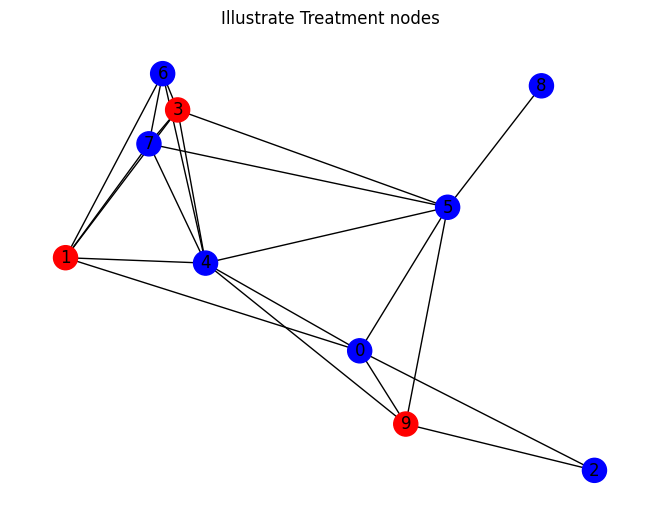

In [74]:
n=10
G, source_nodes, treatment_nodes = make_random_geometric_graph(n, [-7, -7, 0], [7, 7, 0.5], 3, 6)
print(f"# Source: {len(source_nodes)}; # treatment: {len(treatment_nodes)}; # Components = {nx.number_connected_components(G)}")
draw_treatment_visual(G)

# Source: 2; # treatment: 1


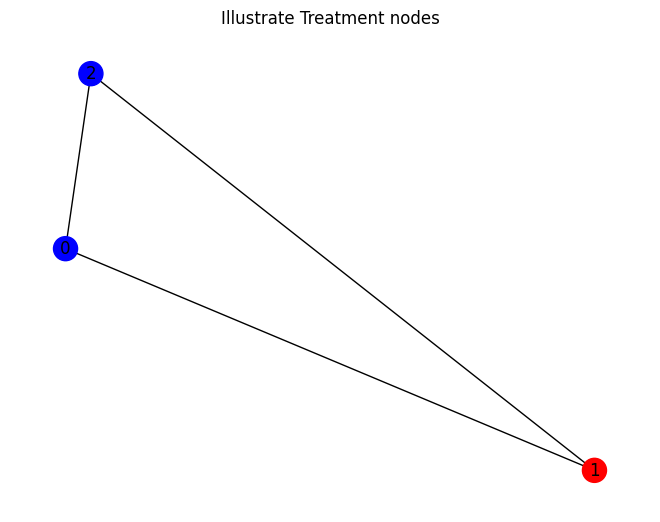

In [79]:
n=3
G, source_nodes, treatment_nodes = make_small_test_graph(n, 3, 0.1, 1)
print(f"# Source: {len(source_nodes)}; # treatment: {len(treatment_nodes)}")
draw_treatment_visual(G)

In [ ]:
G.nodes[0]

In [80]:
G = G.to_directed()

In [93]:
Path = {}  # Set of shortest paths from each source node i to each treatment node j
NLinks = {}  # Number of edges in each path
L = {}  # Length of each path (distance)

for i in source_nodes:
    for j in treatment_nodes:
        path = nx.shortest_path(G, source=i, target=j, weight='distance')
        Path[i, j] = path
        NLinks[i, j] = len(path)-1
        L[i, j] = nx.path_weight(G, path, weight='distance')

In [123]:
LE = {e: G.edges[e]['distance'] for e in G.edges}  # Length of edge e
EL = {v: G.nodes[v]['pos'][2] for v in G.nodes}  # Elevation of node v

D = [0.2, 0.25, 0.3, 0.35, 0.40, 0.45]  # Pipe diameters
CP = {0.05: 8.7, 0.06: 9.5, 0.08: 11,
                       0.1: 12.6, 0.15: 43.5, 0.2: 141,
                       0.25: 151, 0.3: 161, 0.35: 180,
                       0.4: 190, 0.45: 200}  # Cost per unit of pipe

SR = {}  # Production at Source node i
CAP = {}  # Capacity at treatment node j

for node in source_nodes:
    G.nodes[node]['production'] = 1.8
    SR[node] = 1.8

total_flow = sum(SR.values())

for node in treatment_nodes:
    G.nodes[node]['capacity'] = 1000
    CAP[node] = 1000

Vmin = 0.6
Vmax = 3

CE = 25  # Cost of Excavation
CB = 6  # Cost of Bedding
TR = 44000  # Fixed Cost of Treatment Plant
TRFlow = 100  # Variable Cost of Treatment
PICost = 30  

PF = {'0.05': 8.7, '0.06': 9.5, '0.08': 11,
                       '0.1': 12.6, '0.15': 43.5, '0.2': 141,
                       '0.25': 151, '0.3': 161, '0.35': 180,
                       '0.4': 190, '0.45': 200}  # Fixed Cost of Piping

CT = 10000000  # Cost of trucking
M = 1e6

Smin = 0.01
Smax = 0.1
W = 0.5  # Buffer Width

In [124]:
m = gp.Model()

In [125]:
# DECISION VARIABLES

x = m.addVars(Path.keys(), vtype=GRB.BINARY, name=[f'x_({i}{j})' for i, j in Path.keys()])  # Path ij used
y = m.addVars(treatment_nodes, vtype=GRB.BINARY, name=[f'y_{j}' for j in treatment_nodes])  # treatment at node j
z = m.addVars(G.edges, vtype=GRB.BINARY, name=[f'z_{e}' for e in G.edges])  # edge e used

d_es_names = []
for e in G.edges:
    for s in D:
        d_es_names.append(f"d_{e}_{s}")

d_es = m.addVars(G.edges, D, vtype=GRB.BINARY, name=d_es_names)  # Pipe size s at edge e

# Recourse Amount
r = m.addVars(source_nodes, vtype=GRB.CONTINUOUS, lb=0.0, name=[f'r_{i}' for i in source_nodes])  # flow handled at trucking at edge e

# Flow in Edge e
Q = m.addVars(G.edges, vtype=GRB.CONTINUOUS, lb=0.0, name=[f'q_{e}' for e in G.edges])  # Flow in Edge e

# Node Elevation
el = m.addVars(G.nodes, vtype=GRB.CONTINUOUS, name=[f'el_{v}' for v in G.nodes])  # Elevation at node el_v

# Path Flow
p = m.addVars(list(Path.keys()), vtype=GRB.CONTINUOUS, lb = 0.0, name=[f"p_{i}{j}" for i, j in Path.keys()])

m.update()

In [126]:
# CONSTRAINTS

# NODE PRODUCTION MINUS RECOURSE
node_prod_rec = m.addConstrs(p[i, j] >= (SR[i] * x[i, j]) - r[i] for i, j in Path.keys())



# TREATMENT CAPACITY
# treat_cap = m.addConstrs(gp.quicksum(SR[i] * x[i, j] for i in source_nodes) <= CAP[j]*y[j] for j in treatment_nodes)
treat_cap = m.addConstrs(gp.quicksum(p[i, j] for i in source_nodes) <= CAP[j] * y[j] for j in treatment_nodes)

#  NODE ASSIGNMENT
node_assign = m.addConstrs(gp.quicksum(x[i, j] for j in treatment_nodes) == 1 for i in source_nodes)

# PIPE SIZING
pipe_sizing = m.addConstrs(gp.quicksum(d_es[*e, s] for s in D) == z[e] for e in G.edges)

# TODO: Revisit this \/

# EDGE ACTIVATION
Path_e = {}  # Use this for Edge Activiation Constraint
for e, p in Path.items():
    Path_e[e] = [(p[l - 1], p[l]) for l in range(1, len(p))]

edge_activate = m.addConstrs(gp.quicksum(z[e] for e in Path_e[i, j]) >= NLinks[i, j] * x[i, j] for i, j in Path)

# TODO: Revisit Flow Definition

# FLOW DEFINITION
flow_def = m.addConstrs(Q[e] == gp.quicksum(p[i, j] for i, j in Path.keys() if e in Path[i, j]) for e in G.edges)

# FLOW VELOCITY LIMIT
flow_vel = m.addConstrs(Q[e] <= Vmax * gp.quicksum((np.pi / 8) * (s**2) * (d_es[*e, s]) for s in D) for e in G.edges)

# MIN/MAX SLOPE
min_slope = m.addConstrs(el[e[0]] - el[e[1]] >= (LE[e[0], e[1]] * Smin) - (M * (1 - z[e])) for e in G.edges)
max_slope = m.addConstrs(el[e[0]] - el[e[1]] <= (LE[e[0], e[1]] * Smax) + (M * (1 - z[e])) for e in G.edges)


# MANNING'S EQUATION

# # Create new variables for the squared terms
# Q_squared = m.addVars(G.edges, name="Q_squared")
# 
# manning = m.addConstrs(
#     (LE[u, v] * gp.quicksum(d_es[u, v, s] * Q_squared[u, v] / (11.9879 * (s**(8/3)))**2 for s in D) 
#      <= el[u] - el[v] for u, v in G.edges), 
#     name="manning")
# 
# # Add constraints to enforce Q_squared[u, v] = Q[u, v]^2
# q_square = m.addConstrs((Q_squared[u, v] == Q[u, v] * Q[u, v] for u, v in G.edges), name="Q_squared_def")


# PIPES UNDERGROUND
underground = m.addConstrs(el[i] <= EL[i] for i in source_nodes)

m.update()

In [127]:
print(f"Model has {m.NumVars} variables and {m.NumConstrs} constraints.")

Model has 58 variables and 39 constraints.


In [128]:
treat_cost = gp.LinExpr()

for j in treatment_nodes:
    treat_cost.addTerms(TR, y[j])
    for i in source_nodes:
        treat_cost.addTerms(TRFlow * SR[i], x[i, j])


In [129]:
# OBJECTIVE EXPR 2: EXCAVATION COSTS
excav_cost_f = lambda u, v: gp.QuadExpr(CE * (((EL[u] - el[u]) + (EL[v] - el[v])) / 2) * LE[u, v] * gp.quicksum(s + ((2*W)*d_es[u, v, s]) for s in D))

# OBJECTIVE EXPR 3: BEDDING COSTS
bed_cost_f = lambda u, v: gp.LinExpr(CB *  LE[u, v] * gp.quicksum(s + ((2*W)*d_es[u, v, s]) for s in D))


# OBJECTIVE EXPR 4: PIPE COSTS
pipe_cost_f = lambda u, v: gp.LinExpr(LE[u, v] * gp.quicksum(CP[s] * d_es[u, v, s] for s in D))

excav_bed_cost = gp.quicksum(excav_cost_f(u, v) + bed_cost_f(u, v) + pipe_cost_f(u, v) for u, v in G.edges)


In [130]:
# OBJECTIVE EXPR 5: RECOURSE TRUCKING

rec_cost = gp.LinExpr()
for i in source_nodes:
    rec_cost.addTerms(CT, r[i])

In [131]:
m.setObjective(treat_cost + excav_bed_cost + rec_cost, GRB.MINIMIZE)

In [132]:
m.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 39 rows, 58 columns and 143 nonzeros
Model fingerprint: 0x77b8ea26
Model has 72 quadratic objective terms
Variable types: 13 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+06]
  Objective range  [2e+02, 1e+07]
  QObjective range [3e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-02, 1e+06]
Found heuristic solution: objective 4.000000e+16
Presolve removed 31 rows and 29 columns
Presolve time: 0.00s
Presolved: 56 rows, 77 columns, 180 nonzeros
Found heuristic solution: objective 46327.090966
Variable types: 51 continuous, 26 integer (26 binary)
Found heuristic solution: objective 46224.329582

Explored 1 nodes (0 simplex iterations) in 0.02 seconds (0.00 work uni

In [133]:
m.getVars()

[<gurobi.Var x_(01) (value 1.0)>,
 <gurobi.Var x_(21) (value 1.0)>,
 <gurobi.Var y_1[1] (value 1.0)>,
 <gurobi.Var z_(0, 1) (value 1.0)>,
 <gurobi.Var z_(0, 2) (value 0.0)>,
 <gurobi.Var z_(1, 0) (value 0.0)>,
 <gurobi.Var z_(1, 2) (value 0.0)>,
 <gurobi.Var z_(2, 0) (value 0.0)>,
 <gurobi.Var z_(2, 1) (value 1.0)>,
 <gurobi.Var d_(0, 1)_0.2 (value 1.0)>,
 <gurobi.Var d_(0, 1)_0.25 (value 0.0)>,
 <gurobi.Var d_(0, 1)_0.3 (value 0.0)>,
 <gurobi.Var d_(0, 1)_0.35 (value 0.0)>,
 <gurobi.Var d_(0, 1)_0.4 (value 0.0)>,
 <gurobi.Var d_(0, 1)_0.45 (value 0.0)>,
 <gurobi.Var d_(0, 2)_0.2 (value 0.0)>,
 <gurobi.Var d_(0, 2)_0.25 (value 0.0)>,
 <gurobi.Var d_(0, 2)_0.3 (value 0.0)>,
 <gurobi.Var d_(0, 2)_0.35 (value 0.0)>,
 <gurobi.Var d_(0, 2)_0.4 (value 0.0)>,
 <gurobi.Var d_(0, 2)_0.45 (value 0.0)>,
 <gurobi.Var d_(1, 0)_0.2 (value 0.0)>,
 <gurobi.Var d_(1, 0)_0.25 (value 0.0)>,
 <gurobi.Var d_(1, 0)_0.3 (value 0.0)>,
 <gurobi.Var d_(1, 0)_0.35 (value 0.0)>,
 <gurobi.Var d_(1, 0)_0.4 (value 0